In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob

In [2]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [3]:
#Discrete Fourier Transform 

def fft(x):
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(x))))

In [4]:
flag_files = sorted(glob.glob('H1C_Flags/*.flags.h5'))
data_file = "./prisim_hera_test/2020-12-07-21-06-34/simdata/all-simvis-noiseless.uvh5"
model_file = "./prisim_hera_test/2020-12-07-19-10-20/simdata/all-simvis-noiseless.uvh5"

In [5]:

for day,flag_file in enumerate(flag_files):
    #Opening Data/Flags
    hd_data = HERAData(data_file)    
    hd_model = HERAData(model_file) 
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
                 times = flags.time_array[3000:4000])
    d_data, d_flags, d_nsamples = hd_data.read()
    m_data, m_flags, m_nsamples = hd_model.read()
    for bl in d_data:
        d_flags[bl] = flags.flag_array.squeeze()
        m_flags[bl] = flags.flag_array.squeeze()
    hd_data.update(flags=d_flags)
    hd_model.update(flags=m_flags)
    hd_data.x_orientation='north'
    hd_model.x_orientation='north'
    hd_data.write_uvh5(f"data_{day}.uvh5", clobber=True)
    hd_model.write_uvh5(f"model_{day}.uvh5", clobber=True)
    del d_data,d_flags,d_nsamples,m_data,m_flags,m_nsamples,hd_data,hd_model
    #Calculate Gains/Smooth
    redcal.redcal_run(input_data=f'data_{day}.uvh5', clobber=True, solar_horizon=90, verbose=True)
    abscal.post_redcal_abscal_run(data_file = f'data_{day}.uvh5', redcal_file = f'data_{day}.omni.calfits',
                                  model_files = [f"model_{day}.uvh5"], clobber=True, data_solar_horizon=90,
                                  model_solar_horizon=90)
    cs = smooth_cal.CalibrationSmoother(calfits_list=[f'data_{day}.abs.calfits'])
    cs.time_freq_2D_filter(time_scale=21600)
    cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))
    #Apply Smooth Gains
    apply_cal.apply_cal(data_infilename=f'data_{day}.uvh5', data_outfilename=f'data_{day}_smoothcal.uvh5',
                        new_calibration=f'data_{day}.smooth_abs.calfits')
    #Fourier-Filter
    vc = vis_clean.VisClean(f"data_{day}_smoothcal.uvh5")
    vc.read()
    vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
    vc.write_filtered_data(filled_outfilename=f'data_{day}_filtered.uvh5',clobber=True)

antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_0.first.calfits
Now saving omnical gains to data_0.omni.calfits
Now saving omnical visibilities to data_0.omni_vis.uvh5
Now saving redcal metadata to  data_0.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_0.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.0041684032021316
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.03484421029005745
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0047730232554013905
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.002386511627883466
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0011932558139641641
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_0_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_1.first.calfits
Now saving omnical gains to data_1.omni.calfits
Now saving omnical visibilities to data_1.omni_vis.uvh5
Now saving redcal metadata to  data_1.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_1.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.9926629922300325
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.028450011444495823
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0013911355817797025
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006955677908946881
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0003477838954469863
...configuring global_phase_slope_logcal for t

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_1_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_2.first.calfits
Now saving omnical gains to data_2.omni.calfits
Now saving omnical visibilities to data_2.omni_vis.uvh5
Now saving redcal metadata to  data_2.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_2.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.6722978678425044
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.020001534130996514
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0020315847273665415
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0010157923636963523
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00050789618185151
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_2_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_3.first.calfits
Now saving omnical gains to data_3.omni.calfits
Now saving omnical visibilities to data_3.omni_vis.uvh5
Now saving redcal metadata to  data_3.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_3.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.102941792870491
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.013554099275573375
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0028357326784731575
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001417866339274956
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0007089331696416874
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_3_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_4.first.calfits
Now saving omnical gains to data_4.omni.calfits
Now saving omnical visibilities to data_4.omni_vis.uvh5
Now saving redcal metadata to  data_4.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_4.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.9919442368013636
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.07085107845777065
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0004678045253036934
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0002339022626530726
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00011695113132597455
...configuring global_phase_slope_logcal for t

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_4_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_5.first.calfits
Now saving omnical gains to data_5.omni.calfits
Now saving omnical visibilities to data_5.omni_vis.uvh5
Now saving redcal metadata to  data_5.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_5.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.7814208750633838
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.018997286136913205
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006473170166230219
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00032365850831207987
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00016182925415666438
...configuring global_phase_slope_logcal for

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_5_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_6.first.calfits
Now saving omnical gains to data_6.omni.calfits
Now saving omnical visibilities to data_6.omni_vis.uvh5
Now saving redcal metadata to  data_6.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_6.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.328513590240844
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003972297928885126
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0019861489645472794
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0009930744822868385
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0004965372411462115
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_6_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_7.first.calfits
Now saving omnical gains to data_7.omni.calfits
Now saving omnical visibilities to data_7.omni_vis.uvh5
Now saving redcal metadata to  data_7.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_7.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1736741975230194
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.8586257395119902e-05
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 9.293128697786468e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 4.6465643477167195e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.3232821746220913e-06
...configuring global_phase_slope_logcal f

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_7_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_8.first.calfits
Now saving omnical gains to data_8.omni.calfits
Now saving omnical visibilities to data_8.omni_vis.uvh5
Now saving redcal metadata to  data_8.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_8.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.8619624592971746
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.02595453000126754
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0014285789078383082
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0007142894539238721
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0003571447269613704
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_8_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_9.first.calfits
Now saving omnical gains to data_9.omni.calfits
Now saving omnical visibilities to data_9.omni_vis.uvh5
Now saving redcal metadata to  data_9.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_9.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.328346815401511
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.011198407009657456
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.005426100487100095
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.002713050243819471
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0013565251219437363
...configuring global_phase_slope_logcal for the 

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_9_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_10.first.calfits
Now saving omnical gains to data_10.omni.calfits
Now saving omnical visibilities to data_10.omni_vis.uvh5
Now saving redcal metadata to  data_10.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_10.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.6163083234326807
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.021947299744371148
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.008118378917896796
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.004059189459846492
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00202959473003521
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_10_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_11.first.calfits
Now saving omnical gains to data_11.omni.calfits
Now saving omnical visibilities to data_11.omni_vis.uvh5
Now saving redcal metadata to  data_11.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_11.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.489315672888425
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.08375297155651852
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003563582498606403
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001781791249378061
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008908956246995714
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_11_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_12.first.calfits
Now saving omnical gains to data_12.omni.calfits
Now saving omnical visibilities to data_12.omni_vis.uvh5
Now saving redcal metadata to  data_12.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_12.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.2182003157145718
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0348093252865097
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.007384103487581903
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0036920517444661944
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001846025872317216
...configuring global_phase_slope_logcal for the l

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_12_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_13.first.calfits
Now saving omnical gains to data_13.omni.calfits
Now saving omnical visibilities to data_13.omni_vis.uvh5
Now saving redcal metadata to  data_13.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_13.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1666838485247073
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.020797513792433782
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006669410655470225
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00033347053277358056
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00016673526638789663
...configuring global_phase_slope_logcal for

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_13_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_14.first.calfits
Now saving omnical gains to data_14.omni.calfits
Now saving omnical visibilities to data_14.omni_vis.uvh5
Now saving redcal metadata to  data_14.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_14.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 3.1660774948013026
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.003360006455006441
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0016800032275669672
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008400016137908517
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.000420000806897744
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_14_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_15.first.calfits
Now saving omnical gains to data_15.omni.calfits
Now saving omnical visibilities to data_15.omni_vis.uvh5
Now saving redcal metadata to  data_15.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_15.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.7793932604365104
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.03763300095374983
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0026729071673416405
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.001336453583701443
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0006682267918551617
...configuring global_phase_slope_logcal for the

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_15_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_16.first.calfits
Now saving omnical gains to data_16.omni.calfits
Now saving omnical visibilities to data_16.omni_vis.uvh5
Now saving redcal metadata to  data_16.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_16.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


overflow encountered in square
invalid value encountered in reduce


...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.65563115408242
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.010067679613797459
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0017483993332335485
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.0008741996666253328
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.00043709983331436265
...configuring global_phase_slope_logcal for th

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_16_filtered.uvh5


antenna_diameters is not set. Using known values for HERA.



Now running redundant calibration without antennas [] ...
Now calibrating ['nn'] polarization(s)...
    Now calibrating times 2457053.0807914445 through 2457053.2052039444 ...

Now saving firstcal gains to data_17.first.calfits
Now saving omnical gains to data_17.omni.calfits
Now saving omnical visibilities to data_17.omni_vis.uvh5
Now saving redcal metadata to  data_17.redcal_meta.hdf5
The following model files overlap with data files in LST:
model_17.uvh5


Now calibrating nn-polarization...
Selected 171 data baselines and 171 model baselines to load.

    Now calibrating times 2457053.0807914445 through 2457053.2052039444...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the ndim_fft algorithm


invalid value encountered in true_divide
All-NaN slice encountered


...configuring global_phase_slope_logcal for the ndim_fft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 2.3891894295434564
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.1958278275514463e-06
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 5.979139134454718e-07
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 47.16929254241395
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 17.024206816578456
...configuring global_phase_slope_logcal for the li

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
invalid value encountered in true_divide
invalid value encountered in true_divide
Mean of empty slice
Mean of empty slice
Mean of empty slice.
invalid value encountered in double_scalars


...writing to data_17_filtered.uvh5


In [24]:
# hc = io.HERACal("data_0.abs.calfits")
# hc2 = io.HERACal("data_0.smooth_abs.calfits")
# gains, flags, _, _ = hc.read()
# gains2, flags2, i2, a2 = hc2.read()


In [28]:
# plt.plot(data.freqs/1e6, gains[(0,'Jnn')][300]/~flags[(0,'Jnn')][300], label='Gains')
# plt.plot(data.freqs/1e6, gains2[(0,'Jnn')][300]/~flags[(0,'Jnn')][300], label='Smoothed Gains')
# plt.ylabel('Magnitude')
# plt.xlabel('Frequency [MHz]')
# plt.legend()

In [29]:
# hd_data = HERAData(data_file)    
# hd_model = HERAData(model_file) 
# flags = UVFlag(flag_file)
# flags.select(frequencies = flags.freq_array[(flags.freq_array>=130*1e+6) & (flags.freq_array<=170*1e+6)],
#                  times = flags.time_array[3000:4000])
# d_data, d_flags, d_nsamples = hd_data.read()
# m_data, m_flags, m_nsamples = hd_model.read()
# print(d_data.keys())

In [103]:
#Average Before Filter
for day in range(18):
    cfile = f"data_{day}_smoothcal.uvh5"
    hd = HERAData(cfile)
    data_t,flags_t,nsamples_t = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
        nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
            flags_avg[bl] = flags_avg[bl] & flags_t[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
    data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg.uvh5', clobber=True)

invalid value encountered in true_divide


File exists; clobbering


In [101]:
vc = vis_clean.VisClean(f"data_avg.uvh5")
vc.read()
vc.vis_clean(standoff=100, min_dly=300, mode='dpss_leastsq', skip_flagged_edge_freqs=True, 
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
vc.write_filtered_data(filled_outfilename='data_avg_beforefiltered.uvh5',clobber=True)

File exists; clobbering
...writing to data_avg_beforefiltered.uvh5


In [94]:
model_avg, res_avg, info_avg = dspec.fourier_filter(x=data.freqs, data=data[(0,1,'nn')],
                                           wgts=~(flags_avg[(0,1,'nn')]), filter_centers=[0], filter_half_widths=[300e-9],
                                          mode= 'dpss_leastsq',suppression_factors=[1e-9])

In [ ]:
hd = HERAData("data_avg_beforefiltered.uvh5")
data, flags, nsamples = hd.read()
bh = dspec.gen_window('bh',409)
jul = 24*3600             #julian date to seconds
interpolated_times = (hd.times -hd.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
ext = delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min()

plt.plot(delay_blh*1e+9,fft(bh*(data[(0,1,'nn')]))[10]*(data.freqs[1]-data.freqs[0]))
#plt.plot(delay_blh*1e+9,fft(bh*(res_avg+model_avg))[10]*(data.freqs[1]-data.freqs[0]))
# plt.plot(data.freqs/1e+6,abs(data[(0,1,'nn')][10]*(data.freqs[1]-data.freqs[0])))
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')
plt.yscale('log')

In [40]:
#Average After Filter
for day in range(18):
    ffile = f'data_{day}_filtered.uvh5'
    hd = HERAData(ffile)
    data_t,flags_t,nsmaples_t = hd.read()
    if day==0:
        data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
        nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
    else:
        for bl in data_avg:
            data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
            flags_avg[bl] = flags_avg[bl] & flags_t[bl]
            nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
for bl in data_avg:   
    data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
hd.write_uvh5('data_avg_afterfiltered.uvh5', clobber=True)


invalid value encountered in true_divide


In [25]:
# glob.glob('*smooth*')

['HERA_FTsmoothedgains_B.pdf',
 'data_A_smoothcal.uvh5',
 'Day_A_smoothcal.uvh5',
 'HERA_FTsmoothedgains_A.pdf',
 'data_0.smooth_abs.calfits']

In [24]:
# cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))

Mean of empty slice


In [79]:
# rms_avg_before = np.sqrt(np.mean(np.abs(data[(0,1,'nn')]) ** 2, axis=0))

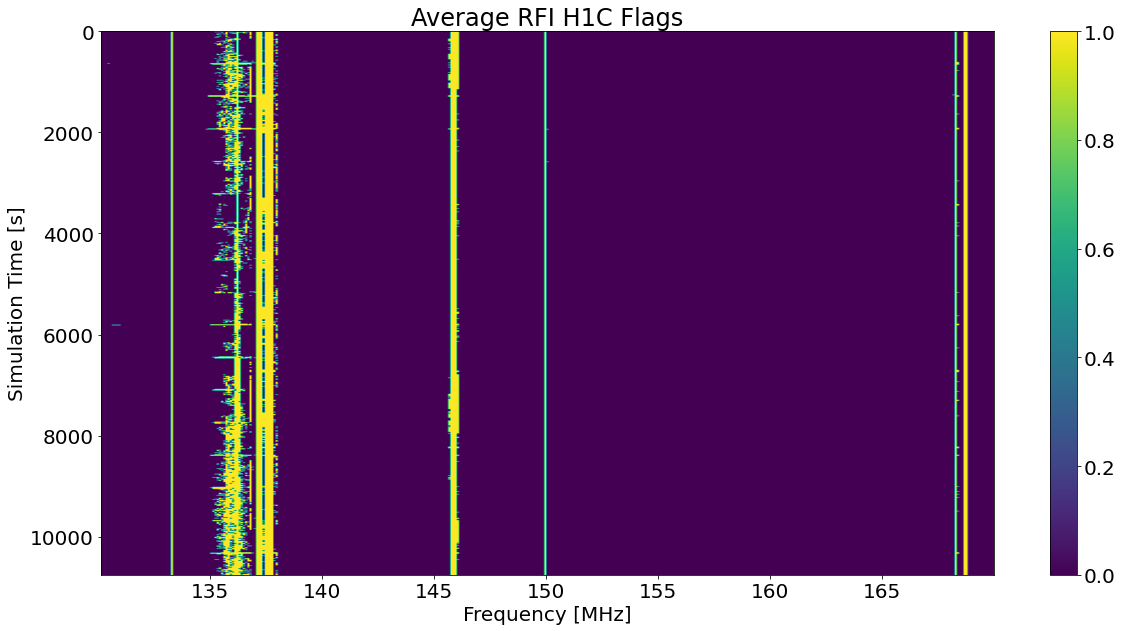

In [89]:
# extents = hd.freqs[0]/1e6, hd.freqs[-1]/1e6,  interpolated_times.max(), interpolated_times.min()
# plt.imshow(flags_avg[(0,1,'nn')],extent=extents, aspect='auto')
# plt.title('Average RFI H1C Flags')
# plt.xlabel('Frequency [MHz]')
# plt.ylabel('Simulation Time [s]')
# plt.colorbar()
# #plt.savefig('Average_RFI.pdf')
# # plt.ylim(8000,7000)